# **HuBMAP + HPA - Hacking the Human Body**

##### **Segment multi-organ functional tissue units**

In [1]:
import os, glob, cv2
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import tifffile as tiff
from tqdm.auto import tqdm
import wandb

plt.style.use("Solarize_Light2")
wandb.login()

/home/linux/miniconda3/envs/python_ai/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/linux/miniconda3/envs/python_ai/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/linux/miniconda3/envs/python_ai/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/linux/miniconda3/envs/python_ai/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
wandb: Currently logged in as: anubhavde. Use 

True

In [2]:
class config:
    BASE_PATH = "../automatic-dissection/"
    TRAIN_PATH = os.path.join(BASE_PATH, "train")

WANDB_CONFIG = {
    'competition': 'HuBMAP',
    '_wandb_kernel': 'neuracort'
}

run = wandb.init(
    project='hubmap-organ-segmentation',
    config=WANDB_CONFIG
)

In [3]:
df = pd.read_csv(
    os.path.join(config.BASE_PATH, "train.csv")
)
df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female


In [4]:
%%capture
wandb.log({"df_train": df})

In [5]:
img_id_1 = 10044
img_1 = tiff.imread(config.BASE_PATH + "train_images/" + str(img_id_1) + ".tiff")
print(img_1.shape)

(3000, 3000, 3)


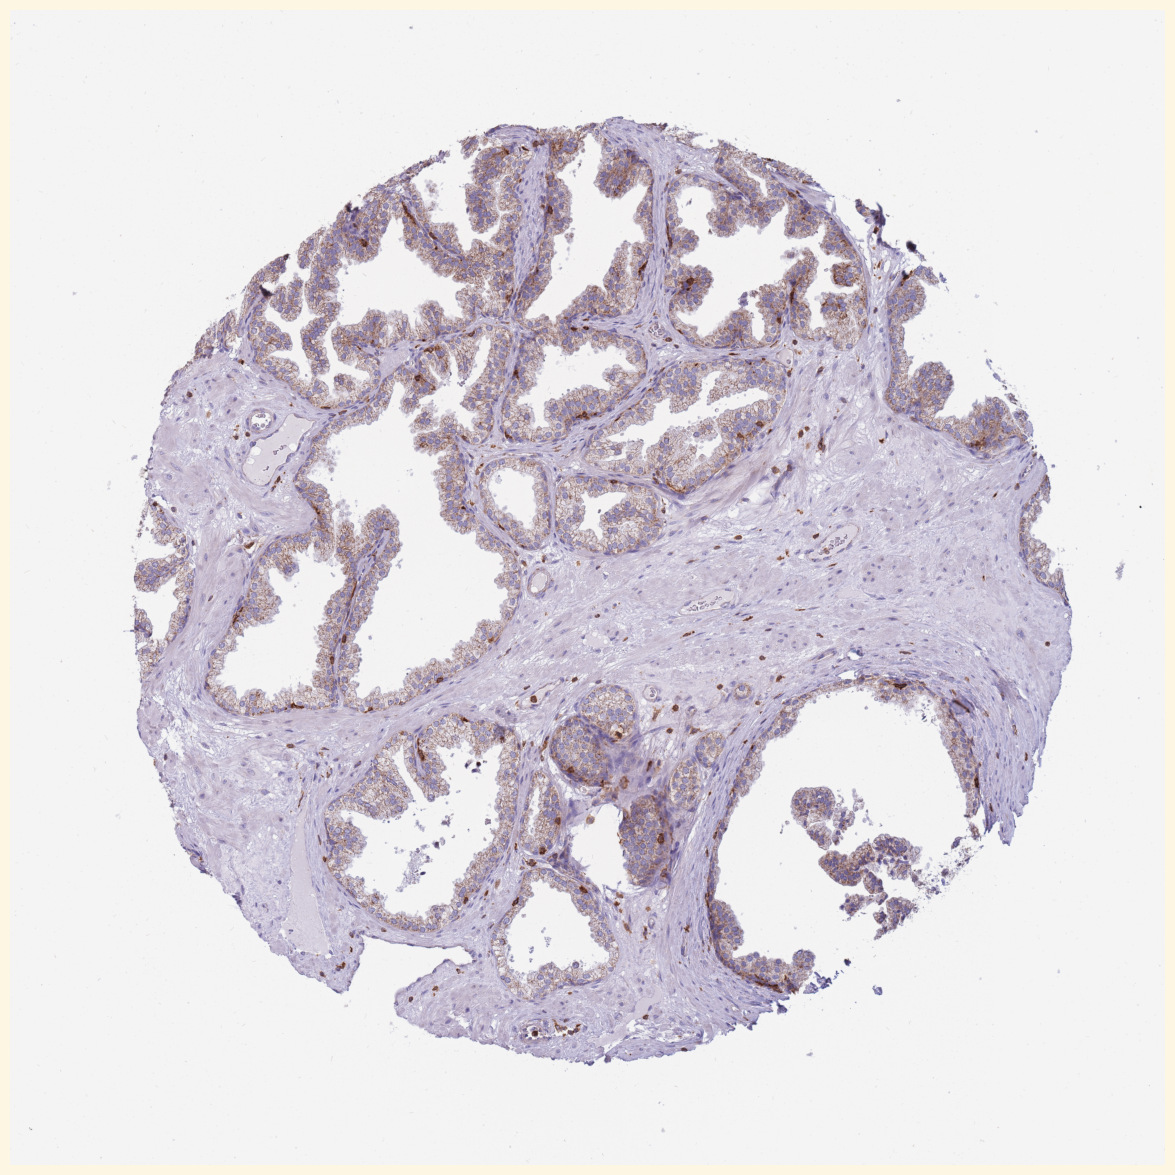

In [6]:
plt.figure(figsize=(15, 15))
plt.imshow(img_1)
plt.axis("off")
wandb.log({"Image Sample 1": plt})

In [7]:
def mask2rle(img):
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle2mask(mask_rle, shape=(1600, 256)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [8]:
mask_1 = rle2mask(df[df["id"] == img_id_1]["rle"].iloc[-1], (img_1.shape[1], img_1.shape[0]))
mask_1.shape

(3000, 3000)

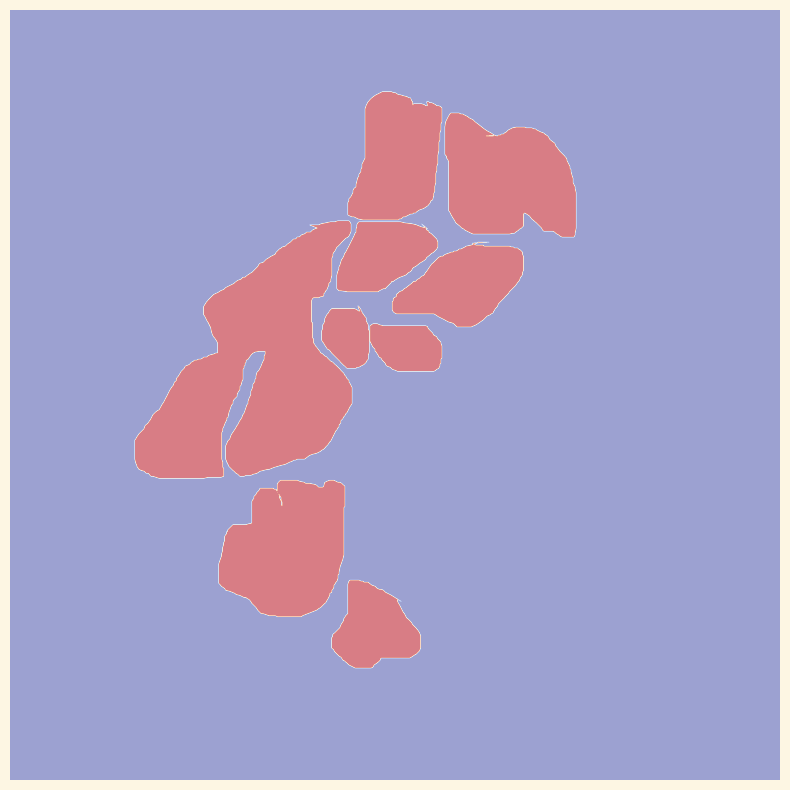

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(mask_1, cmap='coolwarm', alpha=0.5)
plt.axis("off")
wandb.log({"Mask Sample 1": plt})

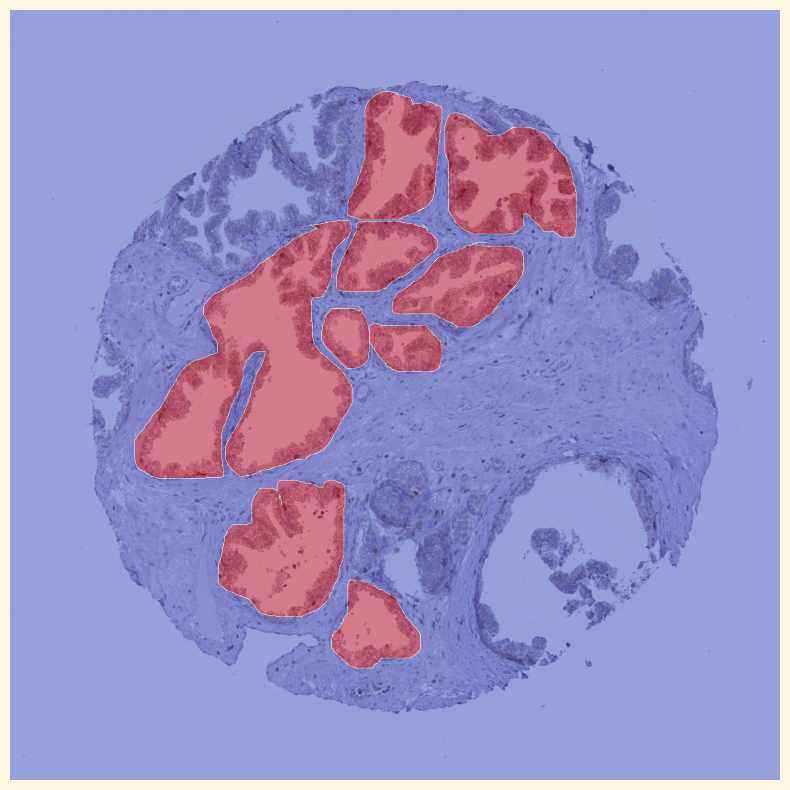

In [10]:
plt.figure(figsize=(10, 10))
plt.imshow(img_1)
plt.imshow(mask_1, cmap='coolwarm', alpha=0.5)
plt.axis("off")
wandb.log({"Image with Mask Sample 1": plt})

In [11]:
image_ids = df.id
image_files = glob.glob(config.BASE_PATH + "/train_images/*")

In [12]:
def save_table(table_name):
    table = wandb.Table(columns=['Id', 'Image', 'Mask', 'Image with Mask'], allow_mixed_types=True)

    for id, img in tqdm(zip(image_ids, image_files), total=len(image_ids)):

        img = tiff.imread(img)
        mask = rle2mask(df[df["id"] == id]["rle"].iloc[-1], (img.shape[1], img.shape[0]))

        plt.figure(figsize=(10, 10))
        plt.axis("off")
        plt.imshow(img)
        plt.imshow(mask, cmap='coolwarm', alpha=0.5)
        plt.savefig("./image.jpg")
        plt.close()

        table.add_data(
            id,
            wandb.Image(img),
            wandb.Image(mask),
            wandb.Image(cv2.cvtColor(cv2.imread(
                "./image.jpg"), cv2.COLOR_BGR2RGB))
        )
    wandb.log({table_name: table})

save_table("Images and Masks Record")

 58%|█████▊    | 205/351 [16:05<12:43,  5.23s/it]

: 

: 